1. Підготовка датасету

In [40]:
import os
import pandas as pd

data_path = "data"
data = pd.DataFrame()
activities = ['idle', 'running', 'stairs', 'walking']

for activity in activities:
    folder_path = os.path.join(data_path, activity)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            df['label'] = activity  # Додаємо стовпець з назвою активності
            data = pd.concat([data, df], ignore_index=True)

In [41]:
data

,accelerometer_X,accelerometer_Y,accelerometer_Z,label
0,1.000776,4.616021,8.576031,idle
1,0.718261,4.209007,8.446744,idle
2,-0.909797,-0.282516,9.203311,idle
3,5.099650,0.148441,8.418014,idle
4,1.762132,-0.162806,9.251195,idle
...,...,...,...,...
193855,5.109226,-15.452178,-1.470040,walking
193856,6.373365,-11.741165,-8.226476,walking
193857,3.289633,-9.993398,-0.383072,walking
193858,-2.978387,-3.050213,1.273715,walking


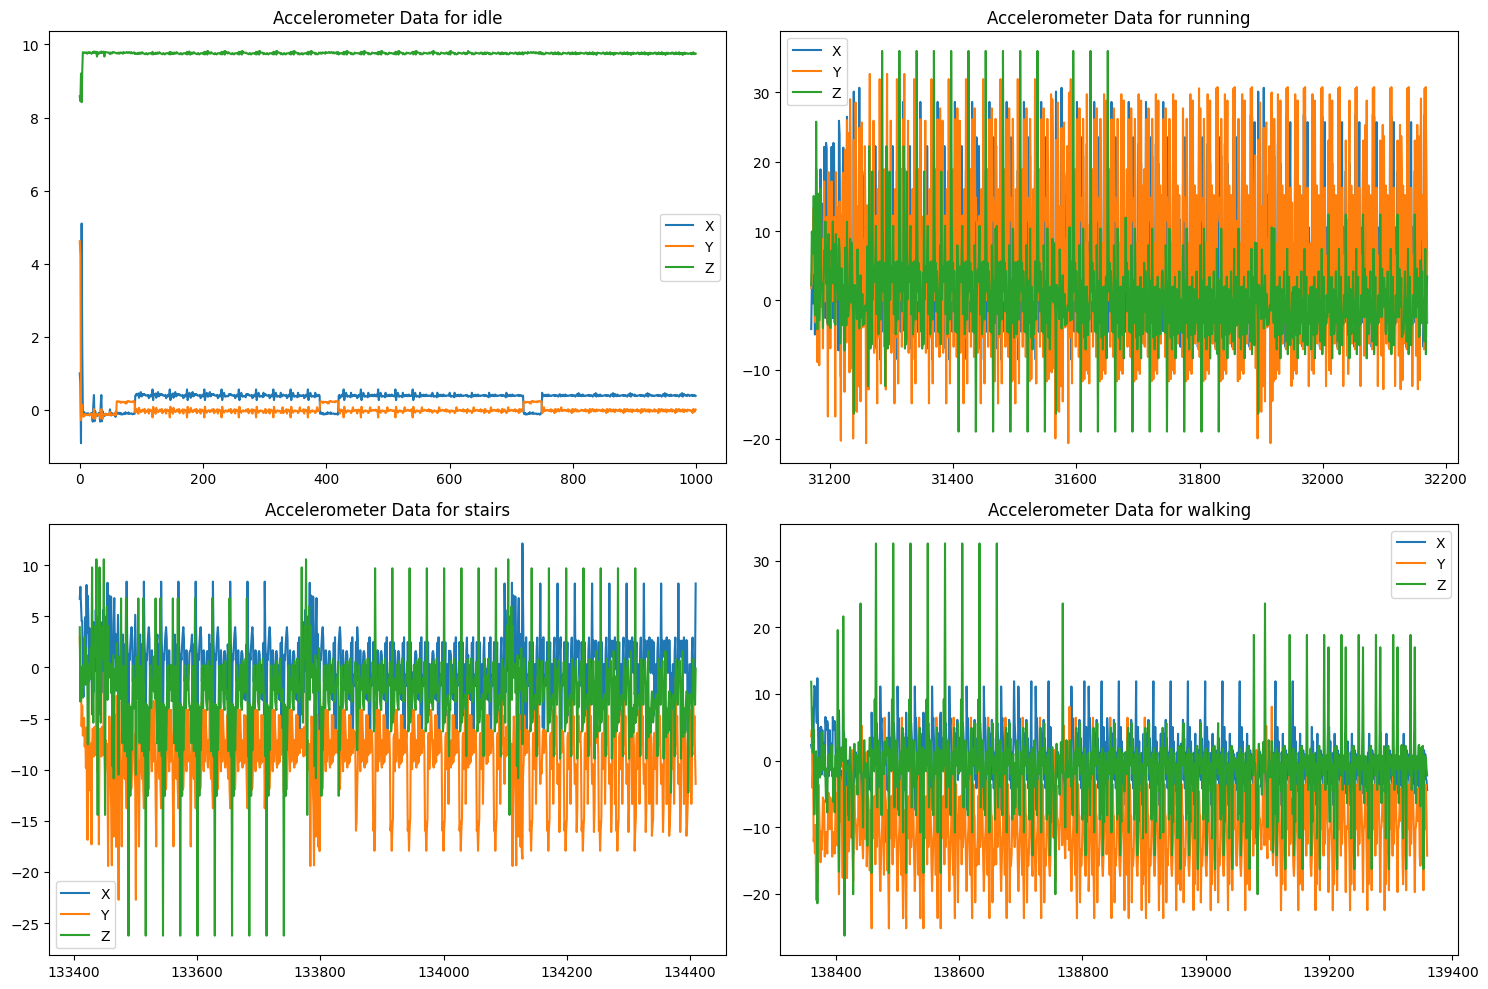

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for i, activity in enumerate(activities):
    activity_data = data[data['label'] == activity]
    plt.subplot(2, 2, i+1)
    plt.plot(activity_data['accelerometer_X'][:1000], label='X')
    plt.plot(activity_data['accelerometer_Y'][:1000], label='Y')
    plt.plot(activity_data['accelerometer_Z'][:1000], label='Z')
    plt.title(f'Accelerometer Data for {activity}')
    plt.legend()
plt.tight_layout()
# plt.savefig('raw_data_visualization.png')
# plt.close()


2. Витягнення часових ознак

In [43]:
import numpy as np

def extract_time_features(segment):
    features = {}
    features['mean'] = np.mean(segment)
    features['std'] = np.std(segment)
    features['max'] = np.max(segment)
    features['min'] = np.min(segment)
    features['energy'] = np.sum(np.square(segment))
    features['mean_abs'] = np.mean(np.abs(segment))
    features['entropy'] = -np.sum(np.log(np.abs(segment) + 1e-9) * np.abs(segment))  # Ентропія
    features['skewness'] = pd.Series(segment).skew()  # Асиметрія
    features['kurtosis'] = pd.Series(segment).kurtosis()  # Куртозис
    features['iqr'] = np.percentile(segment, 75) - np.percentile(segment, 25)  # Інтерквартильний розмах
    return features

def extract_features_from_segment(segment):
    features = {}
    for axis in ['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']:
        axis_features = extract_time_features(segment[axis])
        for key, value in axis_features.items():
            features[f'{axis}_{key}'] = value
    return pd.Series(features)

def segment_data(data, window_size=208, overlap=0.5):
    step = int(window_size * (1 - overlap))
    segments = []
    labels = []
    for start in range(0, len(data) - window_size, step):
        end = start + window_size
        segment = data.iloc[start:end]
        label = segment['label'].mode()[0]  # Більшість для сегмента
        features = extract_features_from_segment(segment)
        segments.append(features)
        labels.append(label)
    
    X_df = pd.DataFrame(segments)
    y_df = pd.DataFrame(labels, columns=['label'])
    
    return X_df, y_df

X, y = segment_data(data)
print(X.shape, y.shape)


(1863, 30) (1863, 1)


In [44]:
X.head()

,accelerometer_X_mean,accelerometer_X_std,accelerometer_X_max,accelerometer_X_min,accelerometer_X_energy,accelerometer_X_mean_abs,accelerometer_X_entropy,accelerometer_X_skewness,accelerometer_X_kurtosis,accelerometer_X_iqr,...,accelerometer_Z_mean,accelerometer_Z_std,accelerometer_Z_max,accelerometer_Z_min,accelerometer_Z_energy,accelerometer_Z_mean_abs,accelerometer_Z_entropy,accelerometer_Z_skewness,accelerometer_Z_kurtosis,accelerometer_Z_iqr
0,0.224249,0.449079,5.099650,-0.909797,52.407666,0.323378,54.559813,6.204246,66.484305,0.512359,...,9.737241,0.162460,9.806650,8.418014,19726.774749,9.737241,-4609.896289,-7.080649,51.809631,0.033519
1,0.396379,0.051206,0.560243,0.268151,33.225494,0.396379,75.615329,0.616345,2.613988,0.043096,...,9.756395,0.022302,9.821015,9.720459,19799.050061,9.756395,-4622.663076,0.629584,0.232139,0.033518
2,0.330699,0.169331,0.560243,-0.124498,28.711244,0.355700,72.207272,-1.936879,2.507004,0.052673,...,9.760355,0.023813,9.821015,9.720459,19815.138706,9.760355,-4625.363708,0.403258,-0.030169,0.028730
3,0.319534,0.179621,0.560243,-0.129287,27.948012,0.349001,71.727109,-1.730183,1.644681,0.038307,...,9.761644,0.024280,9.821015,9.720459,19820.378280,9.761644,-4626.243062,0.269519,-0.199973,0.033519
4,0.381944,0.081809,0.560243,-0.129287,31.735417,0.386410,75.420282,-4.106279,24.824395,0.028731,...,9.761091,0.023279,9.821015,9.720459,19818.124804,9.761091,-4625.865794,0.372055,0.129262,0.029927


3. Нормалізація даних

In [45]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)  # Нормалізуємо ознаки
X_scaled.head()


,accelerometer_X_mean,accelerometer_X_std,accelerometer_X_max,accelerometer_X_min,accelerometer_X_energy,accelerometer_X_mean_abs,accelerometer_X_entropy,accelerometer_X_skewness,accelerometer_X_kurtosis,accelerometer_X_iqr,...,accelerometer_Z_mean,accelerometer_Z_std,accelerometer_Z_max,accelerometer_Z_min,accelerometer_Z_energy,accelerometer_Z_mean_abs,accelerometer_Z_entropy,accelerometer_Z_skewness,accelerometer_Z_kurtosis,accelerometer_Z_iqr
0,-0.380320,-1.605133,-0.966637,1.300542,-1.139032,-1.670252,1.422076,4.864115,9.366071,-1.451331,...,2.217288,-2.139994,-1.230120,1.984153,1.645148,2.342320,-2.276268,-5.272378,4.288036,-1.882262
1,-0.341812,-1.716856,-1.281087,1.460556,-1.140449,-1.646768,1.433298,0.359484,0.056745,-1.549790,...,2.222641,-2.194356,-1.228399,2.109063,1.659484,2.352877,-2.289180,0.225608,-0.309127,-1.882263
2,-0.356506,-1.683687,-1.281087,1.407218,-1.140782,-1.659854,1.431482,-1.698773,0.041152,-1.547781,...,2.223747,-2.193770,-1.228399,2.109063,1.662675,2.355060,-2.291911,0.064221,-0.332507,-1.883843
3,-0.359003,-1.680797,-1.281087,1.406568,-1.140838,-1.662009,1.431226,-1.532147,-0.084535,-1.550795,...,2.224107,-2.193589,-1.228399,2.109063,1.663714,2.355770,-2.292800,-0.031145,-0.347641,-1.882262
4,-0.345041,-1.708263,-1.281087,1.406568,-1.140559,-1.649975,1.433194,-3.447614,3.293991,-1.552804,...,2.223953,-2.193977,-1.228399,2.109063,1.663267,2.355466,-2.292419,0.041971,-0.318296,-1.883448


4. Розбивка на тренувальні та тестові дані

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print(f"Training data size: {X_train.shape}")
print(f"Test data size: {X_test.shape}")

Training data size: (1490, 30)
Test data size: (373, 30)


5. Навчання моделей та оцінка їх продуктивності

SVM та Випадковий ліс

In [48]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

svm_clf = SVC()
svm_clf.fit(X_train, y_train.values.ravel()) 

y_pred_svm = svm_clf.predict(X_test)

print("SVM Classification Report")
print(classification_report(y_test, y_pred_svm))

SVM Classification Report
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00        57
     running       1.00      1.00      1.00       201
      stairs       1.00      0.90      0.95        10
     walking       0.99      1.00      1.00       105

    accuracy                           1.00       373
   macro avg       1.00      0.97      0.99       373
weighted avg       1.00      1.00      1.00       373



In [49]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train.values.ravel())

y_pred_rf = rf_clf.predict(X_test)

print("Random Forest Classification Report")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report
              precision    recall  f1-score   support

        idle       1.00      0.98      0.99        57
     running       1.00      1.00      1.00       201
      stairs       1.00      1.00      1.00        10
     walking       1.00      1.00      1.00       105

    accuracy                           1.00       373
   macro avg       1.00      1.00      1.00       373
weighted avg       1.00      1.00      1.00       373



- Матриці помилок для кожної моделі

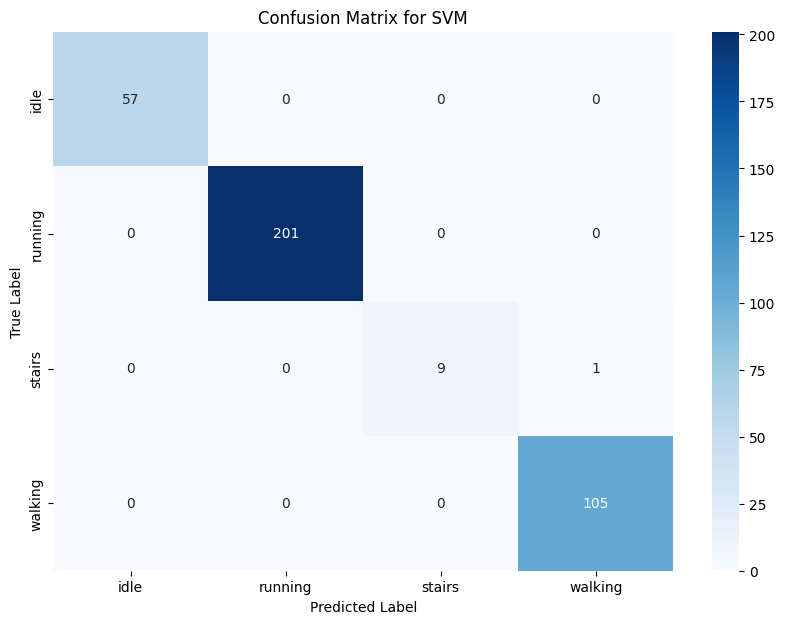

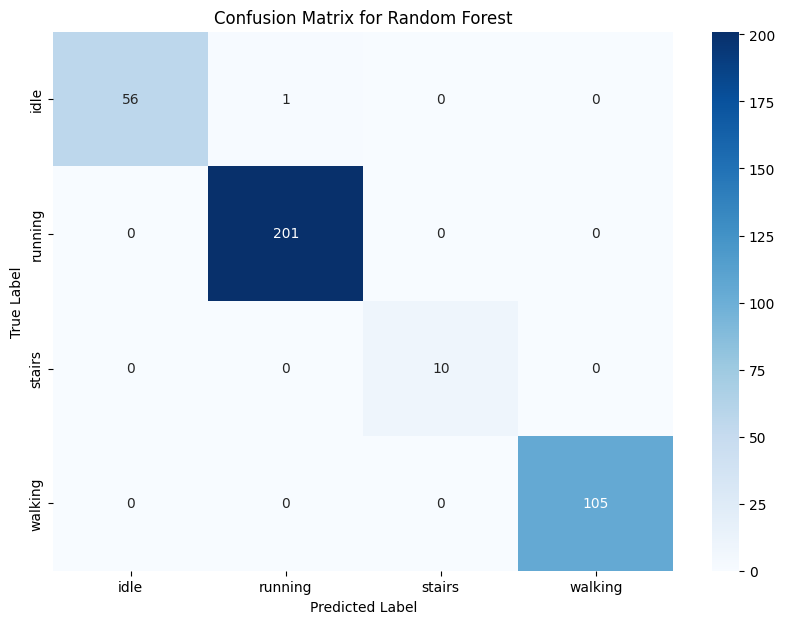

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=activities, yticklabels=activities)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'confusion_matrix_{model_name}.png')
    plt.show()

plot_confusion_matrix(y_test, y_pred_svm, "SVM")

plot_confusion_matrix(y_test, y_pred_rf, "Random Forest")


6. Перехресна перевірка

In [51]:
from sklearn.model_selection import cross_val_score

svm_clf = SVC()
svm_cv_scores = cross_val_score(svm_clf, X_scaled, y.values.ravel(), cv=10)  # Виконуємо перехресну перевірку

print("SVM Cross-Validation Results:")
print(f"Mean accuracy: {svm_cv_scores.mean():.4f}")
print(f"Standard deviation: {svm_cv_scores.std():.4f}")

rf_clf = RandomForestClassifier()
rf_cv_scores = cross_val_score(rf_clf, X_scaled, y.values.ravel(), cv=10)  # Виконуємо перехресну перевірку

print("Random Forest Cross-Validation Results:")
print(f"Mean accuracy: {rf_cv_scores.mean():.4f}")
print(f"Standard deviation: {rf_cv_scores.std():.4f}")


SVM Cross-Validation Results:
Mean accuracy: 0.9866
Standard deviation: 0.0141
Random Forest Cross-Validation Results:
Mean accuracy: 0.9828
Standard deviation: 0.0120


7. Відбір ознак та порівняння моделей за всіма ознаками та відібраними ознаками

In [52]:
from sklearn.feature_selection import SelectKBest, f_classif

def select_best_features(X_train, y_train, k=10):
    selector = SelectKBest(score_func=f_classif, k=k)
    X_new = selector.fit_transform(X_train, y_train)
    return X_new, selector

X_train_best, selector = select_best_features(X_train, y_train.values.ravel(), k=10)

print("Selected feature indices:", selector.get_support(indices=True))
print("Selected features:", X_train.columns[selector.get_support(indices=True)])


Selected feature indices: [ 1  2  5 10 11 12 15 16 19 20]
Selected features: Index(['accelerometer_X_std', 'accelerometer_X_max',
       'accelerometer_X_mean_abs', 'accelerometer_Y_mean',
       'accelerometer_Y_std', 'accelerometer_Y_max',
       'accelerometer_Y_mean_abs', 'accelerometer_Y_entropy',
       'accelerometer_Y_iqr', 'accelerometer_Z_mean'],
      dtype='object')


In [53]:
def evaluate_model_on_all_features(X_train, X_test, y_train, y_test):
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train.values.ravel())
    
    y_pred_rf_all = rf_clf.predict(X_test)
    print("Random Forest Classification Report (All Features):")
    print(classification_report(y_test, y_pred_rf_all))

    all_features_cv_scores = cross_val_score(rf_clf, X_train, y_train.values.ravel(), cv=10)
    print(f"10-fold CV Accuracy (All Features): {all_features_cv_scores.mean():.4f}")

def evaluate_model_on_selected_features(X_train_best, X_test_best, y_train, y_test):
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train_best, y_train.values.ravel())
    
    y_pred_rf_selected = rf_clf.predict(X_test_best)
    print("Random Forest Classification Report (Selected Features):")
    print(classification_report(y_test, y_pred_rf_selected))

    selected_features_cv_scores = cross_val_score(rf_clf, X_train_best, y_train.values.ravel(), cv=10)
    print(f"10-fold CV Accuracy (Selected Features): {selected_features_cv_scores.mean():.4f}")

In [54]:
evaluate_model_on_all_features(X_train, X_test, y_train, y_test)
print("\n")

X_test_best = selector.transform(X_test)
evaluate_model_on_selected_features(X_train_best, X_test_best, y_train, y_test)

Random Forest Classification Report (All Features):
              precision    recall  f1-score   support

        idle       1.00      1.00      1.00        57
     running       1.00      1.00      1.00       201
      stairs       1.00      1.00      1.00        10
     walking       1.00      1.00      1.00       105

    accuracy                           1.00       373
   macro avg       1.00      1.00      1.00       373
weighted avg       1.00      1.00      1.00       373

10-fold CV Accuracy (All Features): 0.9919


Random Forest Classification Report (Selected Features):
              precision    recall  f1-score   support

        idle       1.00      0.98      0.99        57
     running       1.00      1.00      1.00       201
      stairs       1.00      0.80      0.89        10
     walking       0.98      1.00      0.99       105

    accuracy                           0.99       373
   macro avg       0.99      0.95      0.97       373
weighted avg       0.99      0.